purpose of this notebook is to finetune the "dslim/bert-base-NER" model

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


In [3]:
full_dataset = Dataset.from_parquet("data/combined_ner_examples.parquet")


Generating train split: 20041 examples [00:00, 605204.38 examples/s]


In [4]:
full_dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 20041
})

In [5]:
val_set_size = 1000
val_start = len(full_dataset) - val_set_size
val_start

19041

In [6]:


# Split the dataset into train and validation sets
train_dataset = full_dataset.select(range(val_start))  # Select training rows
val_dataset = full_dataset.select(range(val_start, len(full_dataset)))  # Select last 1000 rows for validation

# Combine them into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 19041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1000
    })
})

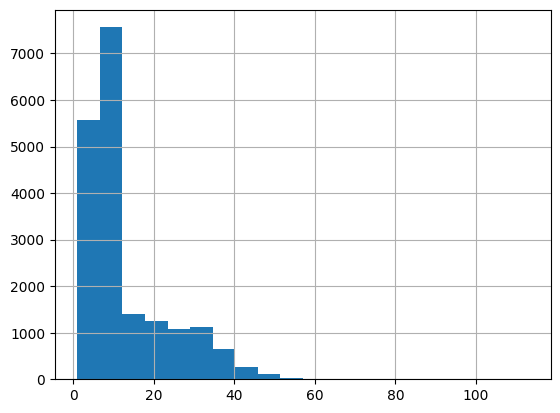

In [8]:
dataset['train'].to_pandas()['tokens'].apply(len).hist(bins=20);

In [9]:
from transformers import AutoTokenizer

# Load the tokenizer for distilbert-based NER
tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")

# Function to tokenize the input and align labels with tokens
def tokenize_and_align_labels(example):
    # Tokenize 'tokens' while keeping track of word boundaries
    tokenized_inputs = tokenizer(
        example['tokens'], 
        is_split_into_words=True, 
        truncation=True, 
        padding='max_length',
        max_length=64,
    )
    
    # Get the word_ids (mapping from tokens to original words)
    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)  # Special tokens ([CLS], [SEP], etc.)
        elif word_idx != previous_word_idx:
            aligned_labels.append(example['ner_tags'][word_idx])  # Assign the label to the first token of each word
        else:
            aligned_labels.append(-100)  # Subword tokens get label -100

        previous_word_idx = word_idx

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels)



Map: 100%|██████████| 1000/1000 [00:00<00:00, 2370.30 examples/s]


In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 19041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [11]:
tokenized_dataset['validation'][0]

{'id': 19041,
 'tokens': ['I',
  'am',
  'planning',
  'a',
  'trip',
  'to',
  'alexandria,',
  'la',
  'next',
  'month.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 5, 6, 0, 0],
 'input_ids': [101,
  146,
  1821,
  3693,
  170,
  3868,
  1106,
  23280,
  20192,
  3276,
  3464,
  117,
  2495,
  1397,
  2370,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': [-100,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  -100,
  -100,
  -100,
  -100,
  6,
  0,
  0,
  -100,
 

In [12]:
def postprocess_predictions_and_labels(predictions, references):
    true_predictions = []
    true_labels = []
    cmp_count = 0

    for prediction, reference in zip(predictions, references):
        # Only keep labels that are not -100
        true_labels_example = [label for label in reference if label != -100]
        
        # Align predictions: Remove predictions for which the corresponding reference label is -100
        true_predictions_example = [pred for pred, ref in zip(prediction, reference) if ref != -100]

        # Ensure the length of predictions and labels matches
        if len(true_predictions_example) == len(true_labels_example):
            true_labels.append(true_labels_example)
            true_predictions.append(true_predictions_example)
            cmp_count += 1
        else:
            # Log or handle the error (example-level mismatch)
            # print(f"Skipping example due to mismatch: predictions ({len(true_predictions_example)}), labels ({len(true_labels_example)})")
            continue  # Skip this example

    # Flatten the lists (convert from list of lists to a single list)
    true_predictions = [pred for sublist in true_predictions for pred in sublist]
    true_labels = [label for sublist in true_labels for label in sublist]
    print(f"cmp_count = {cmp_count} out of {len(predictions)}")

    return true_predictions, true_labels


In [13]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    
    # Post-process the predictions and labels to remove -100 values
    true_predictions, true_labels = postprocess_predictions_and_labels(predictions, labels)

    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=true_predictions, references=true_labels)
    precision = precision_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    recall = recall_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    f1 = f1_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [14]:


# Load the pre-trained model
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER", num_labels=9)

# Define the LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,  # Task type is token classification (NER)
    r=8,  # Low-rank dimension (you can experiment with this)
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=['q_lin']  # LoRA is applied to query layer
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)


In [15]:


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Output directory
    evaluation_strategy="epoch",      # Evaluate at the end of every epoch
    learning_rate=2e-5,               # Learning rate
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    num_train_epochs=12,               # Number of training epochs
    weight_decay=0.01,                # Weight decay
    logging_dir='./logs',             # Directory for logging
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,                  # LoRA-wrapped model
    args=training_args,                # Training arguments
    train_dataset=tokenized_dataset['train'],  # Training dataset
    eval_dataset=tokenized_dataset["validation"],  # Validation dataset (if available)
    tokenizer=tokenizer,               # Tokenizer
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
)

# Fine-tune the model
trainer.train()


/home/jupyter/new_env/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.064000,0.191208,0.139165,0.750614,0.139165,0.233110
2,0.042900,0.106333,0.180915,0.761024,0.180915,0.291246
3,0.032400,0.057788,0.206759,0.756520,0.206759,0.324062
4,0.026200,0.039453,0.187447,0.757323,0.187447,0.299817
5,0.026200,0.030271,0.179494,0.764539,0.179494,0.290127
6,0.023500,0.024663,0.168418,0.761753,0.168418,0.275358
7,0.022800,0.021183,0.161886,0.752585,0.161886,0.265950
8,0.022000,0.018402,0.161034,0.754711,0.161034,0.265074
9,0.023200,0.016394,0.163590,0.756431,0.163590,0.268530
10,0.022400,0.015180,0.165578,0.756360,0.165578,0.271265


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 591 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=14292, training_loss=0.030183565106139676, metrics={'train_runtime': 916.7135, 'train_samples_per_second': 249.251, 'train_steps_per_second': 15.59, 'total_flos': 3739197044081664.0, 'train_loss': 0.030183565106139676, 'epoch': 12.0})

In [16]:
import torch
from transformers import AutoTokenizer

# Your text list
text_list = [
    'New York', 'Los Angeles', 'Chicago', 'Philadelphia', 'Dallas',
    'Fort Worth', 'Houston', 'Atlanta', 'Boston', 'Manchester',
    'Washington, D.C.', 'Hagerstown', 'San Francisco', 'Oakland',
    'San Jose', 
    # 'san jose',
    'weather in san jose',
    'weather in Boston',
    'Weather in Boston',
    'weather Boston',
    'Weather Boston',
    'weather',
    'Weather',
    'Boston weather',
    'Boston Weather',
    'I love Pizzahut',
    'I like Starbucks',
]

model = trainer.model

# Function to make predictions and group entities
def predict_ner(text_list):
    model.eval()  # Set the model to evaluation mode

    for text in text_list:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get predictions (logits -> predicted labels)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()[0]
        
        # Map the predictions to labels and tokens
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
        ner_labels = [model.config.id2label[pred] for pred in predictions]

        # Group tokens back into entities
        current_entity = []
        current_label = None
        entities = []

        for token, label in zip(tokens, ner_labels):
            print(token, label)
            # Ignore special tokens like [CLS], [SEP]
            if token in ["[CLS]", "[SEP]"]:
                continue
            # Handle subword tokens (tokens starting with ##)
            if token.startswith("##"):
                current_entity[-1] += token[2:]  # Append the subword without "##"
            elif label.startswith("B-") or (label.startswith("I-") and label != current_label):
                # New entity starts, append the old one
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_entity.append(token)
                current_label = label
            elif label.startswith("I-") and label == current_label:
                # Continue current entity
                current_entity.append(token)
            else:
                # Non-entity token or 'O'
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_label = None

        # Append any remaining entity
        if current_entity:
            entities.append(" ".join(current_entity))

        # Clean up tokens (remove subword tokens and punctuation issues, etc.)
        clean_entities = []
        for entity in entities:
            entity = entity.replace(" ##", "")
            entity = entity.replace(" .", ".")  # Handle punctuation
            entity = entity.replace(" ,", ",")
            clean_entities.append(entity)

        # Print the result for comparison
        print(f"Input: {text}")
        print(f"Predicted entities: {' '.join(clean_entities)}")
        print()

# Run predictions on the text list
predict_ner(text_list)


[CLS] O
New B-LOC
York I-LOC
[SEP] I-LOC
Input: New York
Predicted entities: New York

[CLS] O
Los B-LOC
Angeles I-LOC
[SEP] I-LOC
Input: Los Angeles
Predicted entities: Los Angeles

[CLS] O
Chicago B-LOC
[SEP] O
Input: Chicago
Predicted entities: Chicago

[CLS] O
Philadelphia B-LOC
[SEP] O
Input: Philadelphia
Predicted entities: Philadelphia

[CLS] O
Dallas B-LOC
[SEP] O
Input: Dallas
Predicted entities: Dallas

[CLS] O
Fort B-LOC
Worth I-LOC
[SEP] I-LOC
Input: Fort Worth
Predicted entities: Fort Worth

[CLS] O
Houston B-LOC
[SEP] O
Input: Houston
Predicted entities: Houston

[CLS] O
Atlanta B-LOC
[SEP] O
Input: Atlanta
Predicted entities: Atlanta

[CLS] O
Boston B-LOC
[SEP] O
Input: Boston
Predicted entities: Boston

[CLS] O
Manchester B-ORG
[SEP] I-LOC
Input: Manchester
Predicted entities: Manchester

[CLS] O
Washington B-LOC
, O
D B-LOC
. B-LOC
C I-LOC
. O
[SEP] I-LOC
Input: Washington, D.C.
Predicted entities: Washington D . C

[CLS] O
Ha B-LOC
##gers B-LOC
##town B-LOC
[SEP] O
In

In [22]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load the base model (DistilBERT NER model)
base_model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")

# Load the LoRA-adapted model
peft_config = PeftConfig.from_pretrained("results/checkpoint-14000")
lora_model = PeftModel.from_pretrained(base_model, "results/checkpoint-14000")

# Merge the LoRA weights with the base model
merged_model = lora_model.merge_and_unload()  # This merges LoRA into the base model


In [23]:
# Save the merged model and tokenizer
save_dir = "tmp/merged_distilbert_ner"
merged_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('tmp/merged_distilbert_ner/tokenizer_config.json',
 'tmp/merged_distilbert_ner/special_tokens_map.json',
 'tmp/merged_distilbert_ner/vocab.txt',
 'tmp/merged_distilbert_ner/added_tokens.json',
 'tmp/merged_distilbert_ner/tokenizer.json')

In [24]:
# !huggingface-cli whoami

In [25]:
# !huggingface-cli login

In [26]:
# Upload the merged model
merged_model_dir = "tmp/merged_distilbert_ner"
merged_repo_id = "Mozilla/distilbert-NER-LoRA" 

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)


model.safetensors: 100%|██████████| 261M/261M [00:07<00:00, 35.3MB/s] 
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mozilla/distilbert-NER-LoRA/commit/105fc9c5865a957b6fa91eeb26d6cb602edb01cb', commit_message='Upload tokenizer', commit_description='', oid='105fc9c5865a957b6fa91eeb26d6cb602edb01cb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/distilbert-NER-LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/distilbert-NER-LoRA'), pr_revision=None, pr_num=None)